In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from typing import Literal

from matplotlib import pyplot as plt
from shapely.geometry import Point
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import numpy as np

from s2shores.bathy_debug.temporal_correlation_bathy_estimator_debug import TemporalCorrelationBathyEstimatorDebug
from s2shores.bathy_debug.spatial_correlation_wave_fields_display import (
    build_sinograms_1D_analysis_spatial_correlation,
    build_sinograms_spatial_correlation,
    build_waves_images_spatial_correl,
)
from s2shores.bathy_debug.waves_image_display import (
    create_pseudorgb,
    build_display_waves_image,
    build_display_pseudorgb,
)
from s2shores.bathy_physics import celerity_offshore, period_offshore, wavelength_offshore
from s2shores.generic_utils.image_filters import circular_masking
from s2shores.generic_utils.image_utils import normalized_cross_correlation
from s2shores.generic_utils.signal_utils import find_period_from_zeros
from s2shores.generic_utils.symmetric_radon import symmetric_radon
from s2shores.image_processing.waves_radon import WavesRadon
from s2shores.image_processing.waves_sinogram import WavesSinogram
from s2shores.bathy_debug.display_utils import get_display_title_with_kernel
from s2shores.bathy_debug.sinogram_display import (
    build_sinogram_display, 
    build_sinogram_difference_display,
    build_sinogram_1D_display_master,
    build_sinogram_1D_cross_correlation,
    build_sinogram_1D_display_slave,
    build_sinogram_2D_cross_correlation,
)
from s2shores.global_bathymetry.bathy_config import (
    BathyConfig,
    GlobalEstimatorConfig,
    SpatialCorrelationConfig,
)
from s2shores.waves_exceptions import WavesEstimationError, NotExploitableSinogram
from utils import initialize_sequential_run, read_config

## Coastal Bathymetry Estimation via Spatial Correlation

This notebook implements a bathymetric method using satellite imagery based on **spatial correlation** and the **linear relationship between water depth and wave kinematics**.  
Wave kinematics are inferred through the **spatial correlation of the wave field**, measured from two satellite images acquired within a short time interval.  
By leveraging the theory of linear wave dispersion in shallow water, bathymetry can be estimated from the wavelength of the waves.

## Notebook Objective

This notebook provides an **experimental and interactive** environment to:
- explore and adjust the key processing steps,
- quickly test different parameters and method variations,
- support **iterative development** of the processing workflow in a prototyping context.
## Notebook Summary

1. **Preprocess the images**: Apply filters on the images.
2. **Find the direction**: Calculate the main propagation direction of the waves.
3. **Compute the Radon transforms**: Compute Radon transforms on all images.
4. **Compute the spatial correlation**: Compute the spatial correlations of the radon transform on the main direction.
5. **Compute the wavelength**: Compute the wavelength of the waves based on the period of the spatial correlation.
6. **Compute the delta position**: Compute the depth estimation from the wavelength.

In [3]:
base_path = Path("../TestsS2Shores").resolve()
test_case: Literal["7_4", "8_2"] = "7_4"
method: Literal["spatial_corr", "spatial_dft", "temporal_corr"] = "temporal_corr"

product_path: Path = base_path / "products" / f"SWASH_{test_case}/testcase_{test_case}.tif"
config_path: Path = base_path / f"reference_results/debug_pointswash_{method}/wave_bathy_inversion_config.yaml"
debug_file: Path = base_path / f"debug_points/debug_points_SWASH_{test_case}.yaml"

estimation_point = Point(451.0, 499.0)

In [4]:
config = read_config(config_path=config_path)

# OR

# config = BathyConfig(
#     GLOBAL_ESTIMATOR=GlobalEstimatorConfig(
#         WAVE_EST_METHOD="SPATIAL_CORRELATION",
#         SELECTED_FRAMES=[10, 13],
#         DXP=50,
#         DYP=500,
#         NKEEP=5,
#         WINDOW=400,
#         SM_LENGTH=100,
#         MIN_D=2,
#         MIN_T=3,
#         MIN_WAVES_LINEARITY=0.01,
#     )
# )

If you want to change any parameter of the configuration, modify the values of the object `config` as you would with a dict.  

Example:
```python
config["parameter"] = "new_value"
```

In [5]:
bathy_estimator, ortho_bathy_estimator, ortho_sequence = initialize_sequential_run(
    product_path=product_path,
    point=estimation_point,
    config=config,
)

/home/geoffrey/miniconda3/envs/s2shores_env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [6]:
local_estimator = TemporalCorrelationBathyEstimatorDebug(
    estimation_point,
    ortho_sequence,
    bathy_estimator,
)

if not local_estimator.can_estimate_bathy():
    raise WavesEstimationError("Cannot estimate bathy.")

<Figure size 900x1400 with 0 Axes>

## Center point is out

In [7]:
from s2shores.waves_exceptions import SequenceImagesError, CorrelationComputationError

merge_array = np.dstack([image.pixels for image in ortho_sequence])
shape_y, shape_x = ortho_sequence.shape
ts_mean = np.mean(merge_array[shape_y // 2, shape_x // 2, :])

if not(np.isfinite(ts_mean)) or ts_mean == 0:
    raise SequenceImagesError('Window center pixel is out of border or has a 0 mean.')

## Preprocess images

Modified attributes:
- local_estimator.ortho_sequence.\<elements\>.pixels

In [8]:
from s2shores.generic_utils.image_filters import desmooth, detrend, normalise

if False:
    local_estimator.preprocess_images()
else:
    preprocessing_filters = [(normalise, [])]

    for image in local_estimator.ortho_sequence:
        filtered_image = image.apply_filters(preprocessing_filters)
        image.pixels = filtered_image.pixels

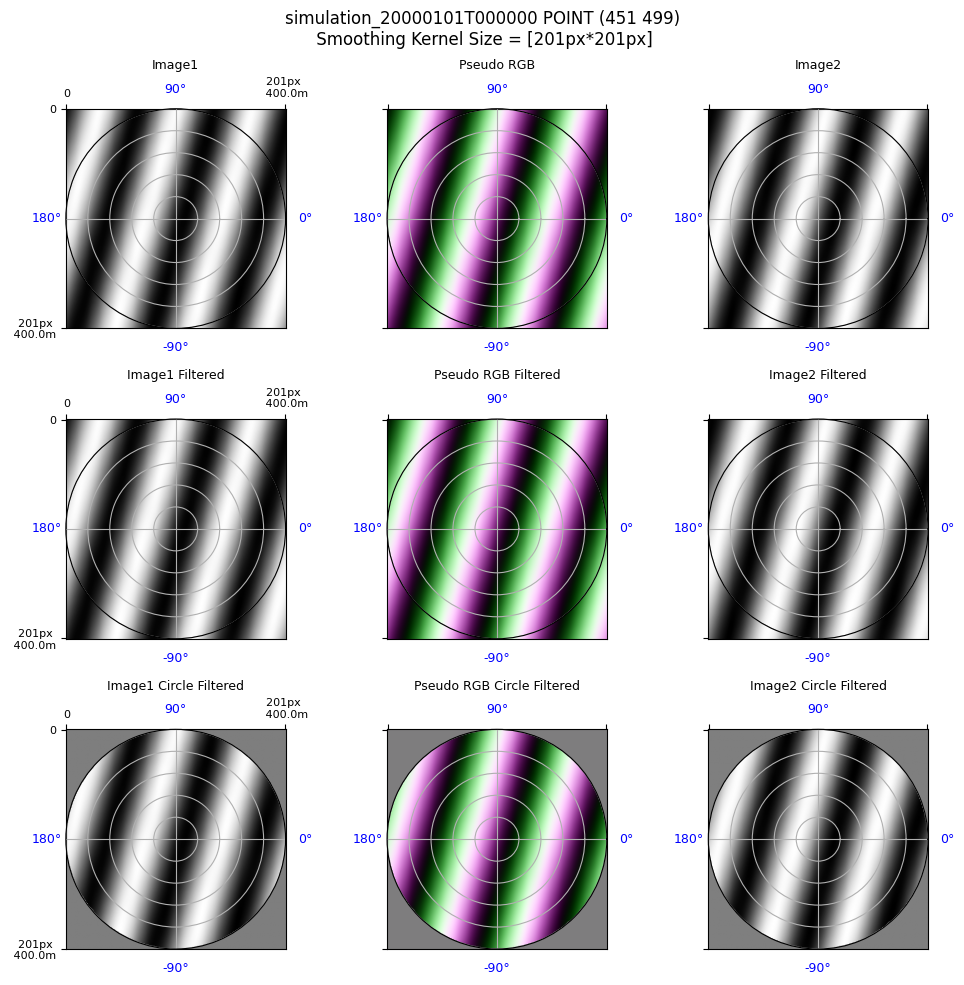

In [9]:
if False:
    build_waves_images_spatial_correl(local_estimator)
else:
    nrows = 3
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    fig.suptitle(get_display_title_with_kernel(local_estimator), fontsize=12)

    first_image = local_estimator.ortho_sequence[0]
    second_image = local_estimator.ortho_sequence[-1]

    def plot_waves_row(
            fig,
            row_number: int,
            pixels1,
            resolution1,
            pixels2,
            resolution2,
            title_suffix: str = "",
            directions: list[tuple[float, int]] = None):
        build_display_waves_image(fig,
                                  axs[row_number, 0],
                                  f'Image1{title_suffix}',
                                  pixels1,
                                  resolution=resolution1,
                                  subplot_pos=[nrows, ncols, 1 + 3 * row_number],
                                  cmap='gray',
                                  directions=directions)
        build_display_pseudorgb(fig,
                                axs[row_number, 1],
                                f'Pseudo RGB{title_suffix}',
                                create_pseudorgb(pixels1, pixels2),
                                resolution=resolution1,
                                subplot_pos=[nrows, ncols, 2 + 3 * row_number],
                                directions=directions,
                                coordinates=False)
        build_display_waves_image(fig,
                                  axs[row_number, 2],
                                  f'Image2{title_suffix}',
                                  pixels2,
                                  resolution=resolution2,
                                  subplot_pos=[nrows, ncols, 3 + 3 * row_number],
                                  directions=directions,
                                  cmap='gray',
                                  coordinates=False)


    # First Plot line = Image1 / pseudoRGB / Image2
    plot_waves_row(fig=fig,
                   row_number=0,
                   pixels1=first_image.original_pixels,
                   resolution1=first_image.resolution,
                   pixels2=second_image.original_pixels, 
                   resolution2=first_image.resolution)
    # Second Plot line = Image1 Filtered / pseudoRGB Filtered/ Image2 Filtered
    plot_waves_row(fig=fig,
                   row_number=1,
                   pixels1=first_image.pixels,
                   resolution1=first_image.resolution,
                   pixels2=second_image.pixels, 
                   resolution2=first_image.resolution,
                   title_suffix=" Filtered")

    # Third Plot line = Image1 Circle Filtered / pseudoRGB Circle Filtered/ Image2 Circle Filtered
    plot_waves_row(fig=fig,
                   row_number=2,
                   pixels1=first_image.pixels * first_image.circle_image,
                   resolution1=first_image.resolution,
                   pixels2=second_image.pixels * second_image.circle_image, 
                   resolution2=first_image.resolution,
                   title_suffix=" Circle Filtered")
    plt.tight_layout()

## Create sequence time series

Modified attributes:
- None


In [10]:
from s2shores.generic_utils.signal_filters import butter_bandpass_filter, detrend_signal, filter_median

if False:
    local_estimator.create_sequence_time_series()
else:
    percentage_points = config.TEMPORAL_CORRELATION.PERCENTAGE_POINTS
    if percentage_points < 0 or percentage_points > 100:
        raise ValueError('Percentage must be between 0 and 100')

    # Create frame stack
    merge_array = np.dstack([image.pixels for image in ortho_sequence])

    # Select pixel positions randomly
    shape_y, shape_x = ortho_sequence.shape
    image_size = shape_x * shape_y
    local_estimator._time_series = np.reshape(merge_array, (image_size, -1))
    np.random.seed(0)  # A seed is used here to reproduce same results
    nb_random_points = round(image_size * percentage_points / 100)
    random_indexes = np.random.randint(image_size, size=nb_random_points)

    sampling_positions_x, sampling_positions_y = np.unravel_index(
        random_indexes, ortho_sequence.shape)
    local_estimator._sampling_positions = (np.reshape(sampling_positions_x, (1, -1)),
                                np.reshape(sampling_positions_y, (1, -1)))

    # Extract and detrend Time-series
    if config.TEMPORAL_CORRELATION.TUNING.DETREND_TIME_SERIES == 1:
        try:
            time_series_selec = detrend_signal(local_estimator._time_series[random_indexes, :], axis=1)
        except ValueError as excp:
            raise SequenceImagesError(
                'Time-series can not be computed because of the presence of nans') from excp
    elif config.TEMPORAL_CORRELATION.TUNING.DETREND_TIME_SERIES == 0:
        time_series_selec = local_estimator._time_series[random_indexes, :]
    else:
        raise ValueError('DETREND_TIME_SERIES parameter must be 0 or 1.')

    # BP filtering
    if config.TEMPORAL_CORRELATION.TUNING.FILTER_TIME_SERIES == 1:
        fps = 1 / local_estimator.sampling_period
        local_estimator._time_series = butter_bandpass_filter(
            time_series_selec,
            lowcut_period=config.TEMPORAL_CORRELATION.TUNING.LOWCUT_PERIOD,
            highcut_period=config.TEMPORAL_CORRELATION.TUNING.HIGHCUT_PERIOD,
            sampling_freq=fps,
            axis=1)
    elif config.TEMPORAL_CORRELATION.TUNING.FILTER_TIME_SERIES == 0:
        time_series = time_series_selec
    else:
        raise ValueError('FILTER_TIME_SERIES parameter must be 0 or 1.')


    local_estimator.metrics['detrend_time_series'] = time_series_selec[0, :]
    local_estimator.metrics['filtered_time_series'] = local_estimator._time_series[0, :]


## Compute temporal correlation

Modified attributes:
- local_estimator.correlation_image.pixels

In [11]:
from s2shores.generic_utils.image_filters import clipping, detrend, gaussian_masking
from s2shores.image_processing.waves_image import WavesImage

correlation_image_filters = [
    (detrend, []),
    (gaussian_masking, [config.TEMPORAL_CORRELATION.TUNING.SIGMA_CORRELATION_MASK]),
    (clipping, [config.TEMPORAL_CORRELATION.TUNING.RATIO_SIZE_CORRELATION]),
]

In [12]:


# indices_x = np.round(local_estimator.distances * np.cos(local_estimator.angles))
# indices_x = np.array(indices_x - np.min(indices_x), dtype=int).T

# indices_y = np.round(local_estimator.distances * np.sin(local_estimator.angles))
# indices_y = np.array(indices_y - np.min(indices_y), dtype=int).T

# xr_s = pandas.Series(indices_x.flatten())
# yr_s = pandas.Series(indices_y.flatten())
# values_s = pandas.Series(local_estimator.correlation_matrix.flatten())

# # if two correlation values have same xr and yr mean of these values is taken
# dataframe = pandas.DataFrame({'xr': xr_s, 'yr': yr_s, 'values': values_s})
# dataframe_grouped = dataframe.groupby(by=['xr', 'yr']).mean().reset_index()
# values = dataframe_grouped['values'].values
# indices_x = dataframe_grouped['xr'].values
# indices_y = dataframe_grouped['yr'].values

# projected_matrix = np.nanmean(local_estimator.correlation_matrix) * np.ones(
#     (np.max(indices_x) + 1, np.max(indices_y) + 1))
# projected_matrix[indices_x, indices_y] = values


# local_estimator.metrics['corr_indices_x'] = indices_x
# local_estimator.metrics['corr_indices_y'] = indices_y
# local_estimator.metrics['projected_corr_raw'] = projected_matrix

# correlation_image = WavesImage(projected_matrix, local_estimator.spatial_resolution)

In [13]:
indices_x = np.round(local_estimator.distances * np.cos(local_estimator.angles))
indices_x = np.array(indices_x - np.min(indices_x), dtype=int).T

indices_y = np.round(local_estimator.distances * np.sin(local_estimator.angles))
indices_y = np.array(indices_y - np.min(indices_y), dtype=int).T

In [14]:
image1 = local_estimator._time_series[:, local_estimator.nb_lags:]
image2 = local_estimator._time_series[:, :-local_estimator.nb_lags]

In [15]:
image1_c = image1 - image1.mean(1)[:, None]
image2_c = image2 - image2.mean(1)[:, None]

In [ ]:
# Sum of squares across rows
ss1 = (image1_c ** 2).sum(1)
ss2 = (image2_c ** 2).sum(1)

: 

In [ ]:
product_deviation = np.sqrt(np.dot(ss1[:, None], ss2[None]))
if np.any(product_deviation == 0):
    raise ValueError(
        'Cross correlation can not be computed because of standard deviation of 0')

In [ ]:
# Finally get corr coeff
cross_correlation =  np.divide(np.dot(image1_c, image2_c.T), product_deviation)

In [ ]:
import pandas

# if two correlation values have same xr and yr mean of these values is taken
dataframe = pandas.DataFrame({
    'xr': indices_x.flatten(),
    'yr': indices_y.flatten(),
    'values': local_estimator.correlation_matrix.flatten(),
})

In [ ]:
from s2shores.generic_utils.image_filters import clipping, detrend, gaussian_masking
from s2shores.image_processing.waves_image import WavesImage

if False:
    correlation_signal = local_estimator.compute_temporal_correlation()
else:
    correlation_image_filters = [
        (detrend, []),
        (gaussian_masking, [config.TEMPORAL_CORRELATION.TUNING.SIGMA_CORRELATION_MASK]),
        (clipping, [config.TEMPORAL_CORRELATION.TUNING.RATIO_SIZE_CORRELATION]),
    ]

    result = local_estimator.correlation_image.original_pixels.copy()
    for processing_filter, filter_parameters in correlation_image_filters:
        print(processing_filter)
        result = processing_filter(result, *filter_parameters)
    filtered_correlation = WavesImage(result, local_estimator.correlation_image.resolution)
    local_estimator.correlation_image.pixels = filtered_correlation.pixels


: 

## Compute radon transform

In [ ]:
if False:
    direction_propagation = local_estimator.compute_radon_transform()
else:
    # Start: WavesRadon(local_estimator.correlation_image, local_estimator.selected_directions)
    sampling_frequency = 1. / local_estimator.correlation_image.resolution

    pixels = circular_masking(image.pixels.copy())
    radon_transform = symmetric_radon(image=pixels, theta=local_estimator.selected_directions)

    local_estimator.radon_transform = {
        direction: radon_transform[:, idx]
        for idx, direction in enumerate(local_estimator.selected_directions)
    }
    # End: WavesRadon(local_estimator.correlation_image, local_estimator.selected_directions)

    # Start: WavesRadon.get_direction_maximum_variance()

    # Start: Sinograms.get_sinograms_variances(selected_directions)
    variances = np.empty(len(local_estimator.selected_directions), dtype=np.float64)
    for result_index, direction in enumerate(local_estimator.selected_directions):
        variances[result_index] = float(np.var(local_estimator.radon_transform[direction]))
    # End: Sinograms.get_sinograms_variances

    index_max_variance = np.argmax(variances)
    direction_propagation = local_estimator.selected_directions[index_max_variance]
    # End: WavesRadon.get_direction_maximum_variance

    # Extract projected sinogram at max var ang from sinogram
    local_estimator.sinogram_maxvar = local_estimator.radon_transform[direction_propagation]

    sinogram_max_var_filters = [(filter_median, [config.TUNING.MEDIAN_FILTER_KERNEL])]

    # Median filtering of the projected sinogram
    filtered_sinogram_maxvar = local_estimator.sinogram_maxvar.apply_filters(sinogram_max_var_filters)
    local_estimator.sinogram_maxvar.values = filtered_sinogram_maxvar.values

    local_estimator.metrics['corr_radon_input'] = local_estimator.radon_transform.pixels
    local_estimator.metrics['radon_transform'] = local_estimator.radon_transform
    local_estimator.metrics['variances'] = variances
    local_estimator.metrics['direction'] = direction_propagation
    local_estimator.metrics['sinogram_max_var'] = local_estimator.sinogram_maxvar.values

: 

## Compute wavelength

Modified attributes:
- None

New variables:
- wavelength

In [19]:
if False:
    wavelength = local_estimator.compute_wavelength(correlation_signal)
else:
    min_wavelength = wavelength_offshore(
        local_estimator.global_estimator.waves_period_min,
        local_estimator.gravity,
    )
    min_period_unitless = int(min_wavelength / local_estimator.augmented_resolution)
    try:
        period, _ = find_period_from_zeros(correlation_signal, min_period_unitless)
        wavelength = period * local_estimator.augmented_resolution
    except ValueError as excp:
        raise NotExploitableSinogram('Wave length can not be computed from sinogram') from excp
    
wavelength

134.68150021791905

## Compute delta position

Modified attributes:
- None

New variables:
- delta_position

In [20]:
if False:
    delta_position = local_estimator.compute_delta_position(correlation_signal, wavelength)
else:
    peaks_pos, _ = find_peaks(correlation_signal)
    if peaks_pos.size == 0:
        raise WavesEstimationError('Unable to find any directional peak')
    argmax_ac = len(correlation_signal) // 2
    relative_distance = (peaks_pos - argmax_ac) * local_estimator.augmented_resolution

    celerity_offshore_max = celerity_offshore(
        local_estimator.global_estimator.waves_period_max,
        local_estimator.gravity,
    )
    spatial_shift_offshore_max = celerity_offshore_max * local_estimator.propagation_duration
    spatial_shift_min = min(-spatial_shift_offshore_max, spatial_shift_offshore_max)
    spatial_shift_max = -spatial_shift_min

    stroboscopic_factor_offshore = local_estimator.propagation_duration / period_offshore(
        1 / wavelength, local_estimator.gravity)
    
    if abs(stroboscopic_factor_offshore) >= 1:
        # unused for s2
        print('test stroboscopie vrai')
        spatial_shift_offshore_max = (
            local_estimator.local_estimator_params['PEAK_POSITION_MAX_FACTOR']
            * stroboscopic_factor_offshore
            * wavelength
        )

    pt_in_range = peaks_pos[np.where(
        (relative_distance >= spatial_shift_min)
        & (relative_distance < spatial_shift_max)
    )]
    if pt_in_range.size == 0:
        raise WavesEstimationError('Unable to find any directional peak')
    argmax = pt_in_range[correlation_signal[pt_in_range].argmax()]
    delta_position = (argmax - argmax_ac) * local_estimator.augmented_resolution

delta_position

-38.800000000000004

## Save wave field estimation

New elements:
- local_estimator.bathymetry_estimations

In [21]:
if False:
    local_estimator.save_wave_field_estimation(estimated_direction, wavelength, delta_position)
else:
    bathymetry_estimation = local_estimator.create_bathymetry_estimation(estimated_direction, wavelength)
    bathymetry_estimation.delta_position = delta_position
    local_estimator.bathymetry_estimations.append(bathymetry_estimation)

bathymetry_estimation.is_physical()

True